# STILL NONSENSE TESTING - IGNORE 

In [2]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

from braincoder.utils.visualize import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate data

In [3]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))
# sfs_seq = np.append(sfs_seq, np.zeros(500))

con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
# con_seq = np.append(con_seq, np.zeros(500))
paradigm = np.vstack([sfs_seq, con_seq])


In [4]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [5]:
bounds = {
    'width_r'  : [0,1.5],          
    'SFp'       : [0, 6],
    'CSp'       : [0, 200] ,
    'width_l'   : [0.68, 0.68],     # we fix width_l in our model
    'crf_exp'   : [0, 5] ,
    'amplitude' : [0, 10],       # Amplitude of TC
    'baseline'  : [-2,2]
}
n_vx = 2
parameters = pd.DataFrame({
    key:np.random.uniform(bounds[key][0], bounds[key][1], n_vx) for key in bounds
}).astype('float32')

n_vx = parameters.shape[0]
idx_cols = sns.color_palette("hsv", n_vx)

In [6]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

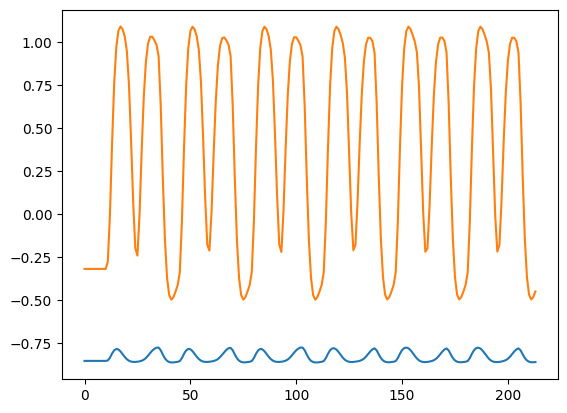

In [7]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=sfs_seq,  
    CON_seq=con_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred)

In [7]:
# import tensorflow as tf

# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# try:
#     if tf.config.list_physical_devices('GPU'):
#         with tf.device('/GPU:0'):
#             # Create a simple convolutional layer
#             conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')

#             # Create a dummy input tensor (batch_size, height, width, channels)
#             input_tensor = tf.random.uniform(shape=(1, 28, 28, 3))

#             # Pass the input through the convolutional layer
#             output_tensor = conv_layer(input_tensor)

#             print("GPU convolution successful!")
#             print("Output shape:", output_tensor.shape)

#     else:
#         print("GPU device not found. Running on CPU.")

# except Exception as e:
#     print(f"Error during GPU convolution:")
#     print(e)

In [8]:
tf.__version__

'2.14.0'

# Classic fitter

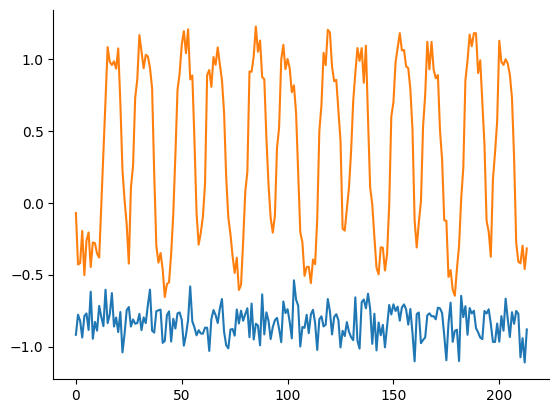

In [8]:

data = model.simulate(noise=.1)
data.plot(legend=False)
sns.despine()
    

In [9]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
cfitter = ParameterFitter(model, data, model.paradigm)
grid_pars = cfitter.fit_grid(
    width_r     =np.linspace(bounds['width_r'][0], bounds['width_r'][1], 5),
    SFp         =np.linspace(bounds['SFp'][0], bounds['SFp'][1], 5),
    CSp         =np.linspace(bounds['CSp'][0], bounds['CSp'][1], 10),
    width_l     =np.linspace(bounds['width_l'][0], bounds['width_l'][1], 5),
    crf_exp     =np.linspace(bounds['crf_exp'][0], bounds['crf_exp'][1], 5),
    amplitude   =[1.0],
    baseline    =[0],
    use_correlation_cost=True
)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars, fixed_pars={'width_l' : 0.68})

/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working with chunk size of 1557632
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


*** Only fitting: ***
 * width_r
 * SFp
 * CSp
 * crf_exp
 * amplitude
 * baseline
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 2


  0%|          | 0/1000 [00:00<?, ?it/s]2025-02-24 15:57:47.102235: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5612c9b5ba70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-02-24 15:57:47.102454: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-02-24 15:57:47.743182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-24 15:57:49.026207: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-02-24 15:57:49.031620: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
Current R2: nan/Best R2: 0.55388:  79%|███████▉  | 790/1000 [00:18<00:04, 43.86it/s]    


/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/tmp/ipykernel_193889/3362790475.py:21: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(bounds[param])
/tmp/ipykernel_193889/3362790475.py:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(bounds[param])


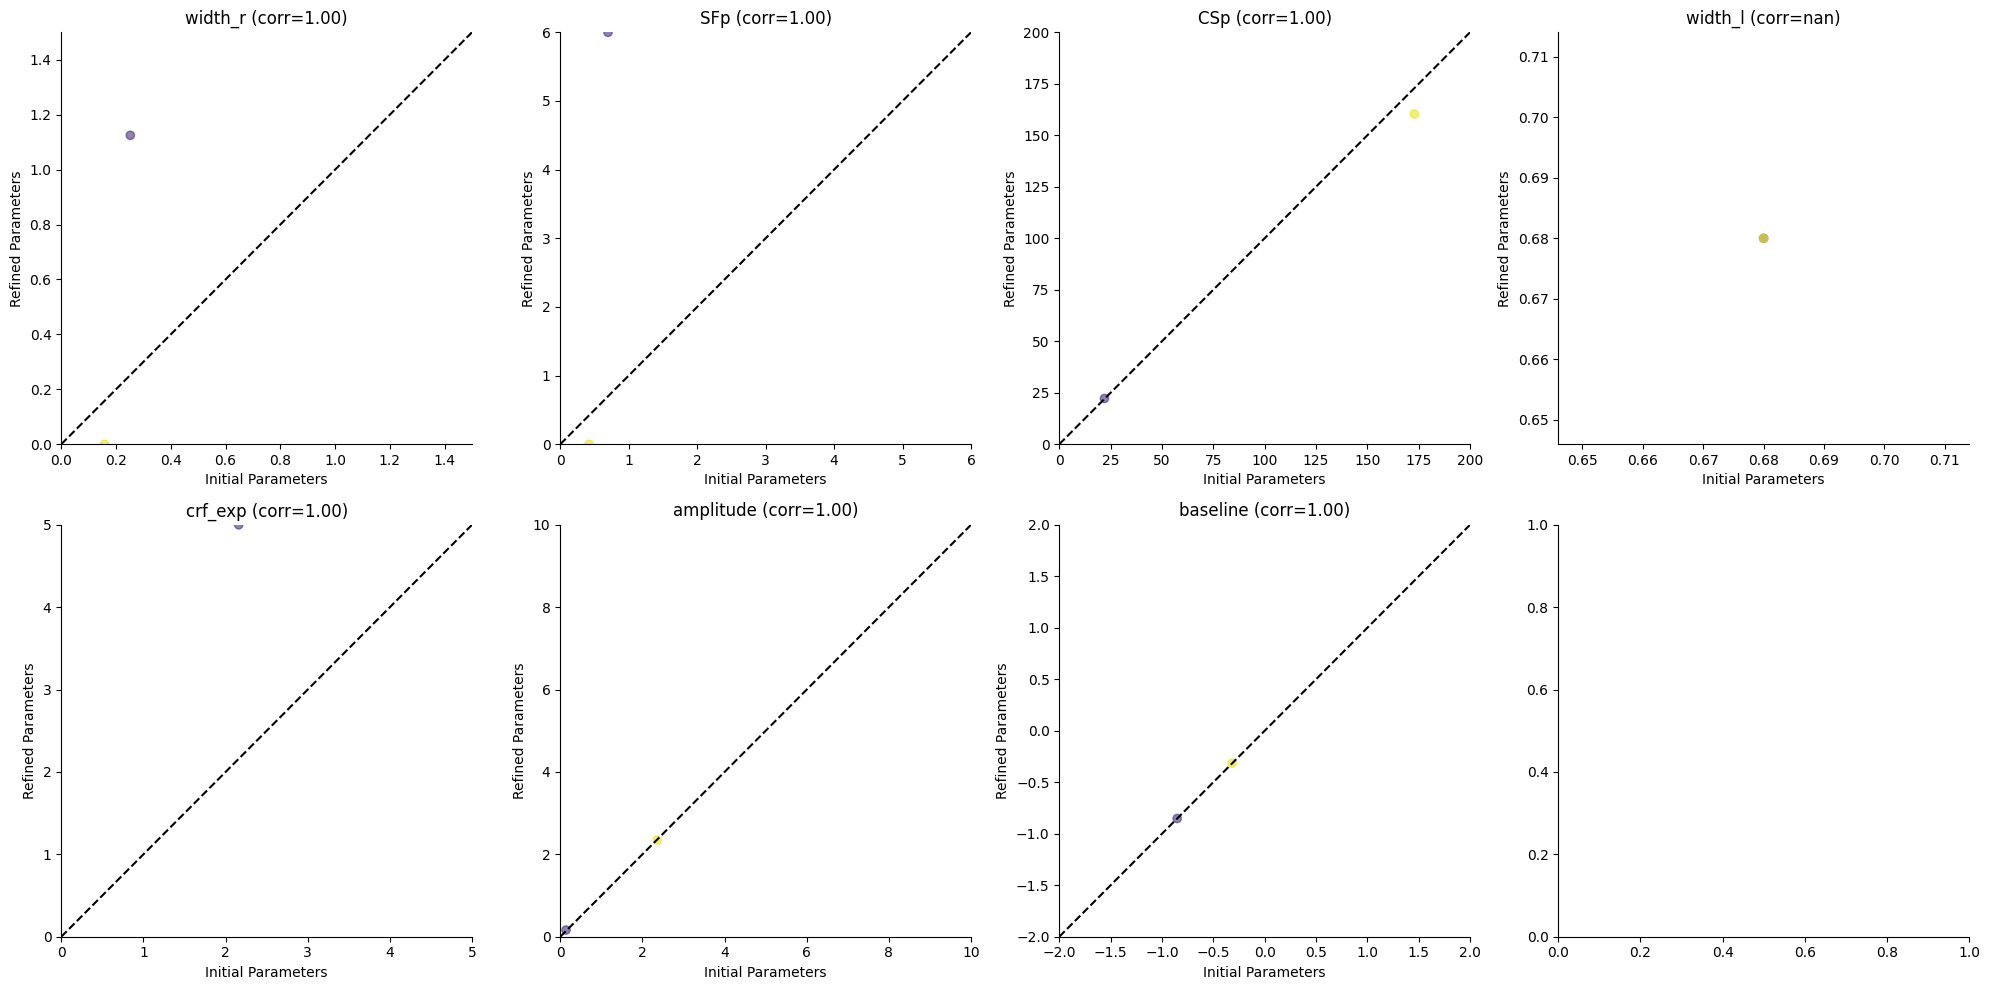

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
param_names = parameters.columns
rsq = cfitter.get_rsq(parameters=refined_pars)
for i, param in enumerate(param_names):
    ax = axs[i]
    ax.scatter(
        parameters[param], 
        refined_pars[param], 
        c=rsq, 
        alpha=0.6,
        cmap='viridis',
        vmin=0, vmax=1,
        )
    corr = np.corrcoef(parameters[param], refined_pars[param])[0, 1]
    ax.set_title(f'{param} (corr={corr:.2f})')
    ax.set_xlabel('Initial Parameters')
    ax.set_ylabel('Refined Parameters')
    ax.plot([bounds[param][0], bounds[param][1]], 
            [bounds[param][0], bounds[param][1]], 'k--')
    ax.set_xlim(bounds[param])
    ax.set_ylim(bounds[param])
    # ax.set_aspect('square')
    sns.despine()

plt.tight_layout()
plt.show()

In [22]:
bfitter = BPRF(model, data, noise_method='fit_tdist')
# bfitter.add_priors_from_bounds(
#     bounds, 
# )
bfitter.add_bijector_from_bounds(
    bounds
)

bfitter.add_prior(pid='SFp', prior_type='normal', loc=3, scale=1)

init_pars = {
    'width_r' : np.ones(n_vx) * 1,
    'SFp' : np.ones(n_vx) * 2,
    'CSp' : np.ones(n_vx) * 100,
    'width_l' : np.ones(n_vx) * 0.68,
    'crf_exp' : np.ones(n_vx) * 1,
    'amplitude' : np.ones(n_vx) * 1, 
    'baseline' : np.ones(n_vx) * 0, 
    'noise_dof' : np.ones(n_vx) * 1, 
    'noise_scale' : np.ones(n_vx) * .5, 
}
init_pars = pd.DataFrame(init_pars)
# init_pars['SFp'][1] = 10
bfitter.fit_mcmc(
    # idx=[0], #,1,2,3,4],
    init_pars=init_pars,
    fixed_pars={'width_l':0.68},
    num_steps=10,
    burnin=5, 
    max_tree_depth=1, 
    # target_accept_prob=0.85, 
)
# print(bfitter.mcmc_stats['elapsed_time'])

Lets run some checks with everything...
log prior=Tensor("PartitionedCall_2:0", shape=(2,), dtype=float32)
log prob [-455.44943 -213.7478 ]
Using tape.gradient to check gradients w/respect to each parameter
Gradient for parameter 0: [ 23.961803 -27.919659]
Gradient for parameter 1: [-4.7344155  7.7338285]
Gradient for parameter 2: [-0.17080265  0.16395146]
Gradient for parameter 3: [0. 0.]
Gradient for parameter 4: [-2.9077759 14.597092 ]
Gradient for parameter 5: [-64.93495  76.31567]
Gradient for parameter 6: [-335.17773   74.64051]
Gradient for parameter 7: [34.09384  63.498768]
Gradient for parameter 8: [ 257.7766  -108.00687]
initial_ll=[-455.44943 -213.7478 ]
Starting NUTS sampling...
Finished NUTS sampling...


In [23]:
len(bfitter.mcmc_stats['step_size'])

9

In [ ]:
from braincoder.bprf_mcmc_hierarchical import * 
bfitter = BPRF_hier(model, data, noise_method='none')
# bfitter.add_priors_from_bounds(
#     bounds, 
# )
# bfitter.add_bijector_from_bounds(
#     bounds
# )
for p in ['width_r', 'SFp', 'CSp', 'width_l', 'crf_exp', 'amplitude']:
    bfitter.add_bijector(
        pid=p, bijector_type='softplus'
    )

bfitter.h_add_param(pid='SFp')

bfitter.h_add_prior(pid=f'SFp_loc', prior_type='normal', loc=5.0, scale=6.0, ) # Example normal prior for location
bfitter.h_add_prior(pid=f'SFp_scale', prior_type='normal', loc=5, scale=5.0,) # Example lognormal for scale (always positive)
# bfitter.add_prior(pid='SFp', prior_type='normal', loc=3, scale=1)

init_pars = {
    'width_r' : np.ones(n_vx) * 1,
    'SFp' : np.ones(n_vx) * 20,
    'CSp' : np.ones(n_vx) * 100,
    'width_l' : np.ones(n_vx) * 0.68,
    'crf_exp' : np.ones(n_vx) * 1,
    'amplitude' : np.ones(n_vx) * 1, 
    'baseline' : np.ones(n_vx) * 0, 
    'noise_dof' : np.ones(n_vx) * 1, 
    'noise_scale' : np.ones(n_vx) * .5, 
}
init_pars = pd.DataFrame(init_pars)
h_init_pars = pd.DataFrame({
    'SFp_loc' : [20,],
    'SFp_scale' : [.01,]
}, index=[0])
bfitter.fit_mcmc_hier(
    # idx=[1], #,1,2,3,4],
    init_pars=init_pars,
    h_init_pars=h_init_pars,
    fixed_pars={'width_l':0.68},
    num_steps=50,
    burnin=5, 
    # step_size=1e-10, 
    max_tree_depth=10, 
    # target_accept_prob=0.85, 
)

# print(bfitter.mcmc_stats['elapsed_time'])

Lets run some checks with everything...
initial_ll=-3147.6318359375
Using tape.gradient to check gradients w/respect to each parameter
 Hierarchical SFp_loc: [-0.8333333]
 Hierarchical SFp_scale: [-399.6008]
 Gradient for width_r: [-0.09652518 -0.00176889]
 Gradient for SFp: [-0.24193826 -0.99079126]
 Gradient for CSp: [3.0774145  0.22233433]
 Gradient for width_l: [0. 0.]
 Gradient for crf_exp: [1276.9453      7.652466]
 Gradient for amplitude: [4033.4023    91.73404]
 Gradient for baseline: [-5897.5537    180.26321]
Starting NUTS sampling...


In [44]:
bfitter.h_mcmc_sampler

,SFp_loc,SFp_scale
0,20.003029,0.010005
1,20.002272,0.010025
2,20.001394,0.010035
3,19.999155,0.010108
4,20.008408,0.010159
5,19.996866,0.010142
6,20.004459,0.010065
7,20.003994,0.010038
8,20.005613,0.010043
9,19.995323,0.010174


In [86]:
import tensorflow as tf
import tensorflow_probability as tfp
from timeit import default_timer as timer

# Define initial states as nested lists
init_params1_a = tf.random.normal([10, 5])
init_params1_b = tf.random.uniform([3, 3])
init_params2_a = tf.random.normal([7, 2])

init_state_nested = [
    [init_params1_a, init_params1_b],
    [init_params2_a]
]

# Define unconstraining bijectors with a matching nested structure
unconstraining_bijectors_nested = [
    [tfp.bijectors.Identity(), tfp.bijectors.Exp()], # Bijectors for the first group
    [tfp.bijectors.Softplus()]                        # Bijectors for the second group
]


def target_log_prob_fn_nested(state_list_nested):
  # state_list_nested will also be a nested list mirroring init_state_nested
  params1_group, params2_group = state_list_nested
  params1_a, params1_b = params1_group
  params2_a = params2_group[0] # Access the single tensor in the second group

  # ... your log probability calculation using params1_a, params1_b, and params2_a ...
  log_prob = tf.reduce_sum(tf.square(params1_a)) + tf.reduce_sum(tf.abs(params1_b)) - tf.reduce_sum(params2_a) # Example calculation
  return log_prob


@tf.function
def bprf_sample_NUTS_nested_list(
    init_state,
    step_size,
    target_log_prob_fn,
    unconstraining_bijectors,
    target_accept_prob=0.85,
    unrolled_leapfrog_steps=1,
    max_tree_depth=10,
    num_steps=50,
    burnin=50):


    def trace_fn(_, pkr):
        return {
            'log_prob': pkr.inner_results.inner_results.target_log_prob,
            'diverging': pkr.inner_results.inner_results.has_divergence,
            'is_accepted': pkr.inner_results.inner_results.is_accepted,
            'accept_ratio': tf.exp(pkr.inner_results.inner_results.log_accept_ratio),
            'leapfrogs_taken': pkr.inner_results.inner_results.leapfrogs_taken,
            'step_size': pkr.inner_results.inner_results.step_size}

    hmc = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn,
        unrolled_leapfrog_steps=unrolled_leapfrog_steps,
        max_tree_depth=max_tree_depth,
        step_size=step_size)

    hmc = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc,
        bijector=unconstraining_bijectors) # bijector can now be a nested list

    adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=hmc,
        num_adaptation_steps=int(0.8 * burnin),
        target_accept_prob=target_accept_prob,
        # NUTS inside of a TTK requires custom getter/setter functions.
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
            inner_results=pkr.inner_results._replace(
                step_size=new_step_size)
        ),
        step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    )

    start = timer()
    # Sampling from the chain.
    samples, stats = tfp.mcmc.sample_chain(
        num_results=burnin + num_steps,
        current_state=init_state, # init_state can now be a nested list
        kernel=adaptive_sampler,
        trace_fn=trace_fn)

    duration = timer() - start
    stats['elapsed_time'] = duration

    return samples, stats


step_size_nested = [ [0.1, 0.05], [0.02] ] # Nested step sizes (optional)


samples_nested, stats_nested = bprf_sample_NUTS_nested_list(
    init_state=init_state_nested,
    step_size=step_size_nested,
    target_log_prob_fn=target_log_prob_fn_nested,
    unconstraining_bijectors=unconstraining_bijectors_nested,
    num_steps=100)

# samples_nested will now be a nested list:
# samples_nested = [ [samples_params1_a, samples_params1_b], [samples_params2_a] ]

samples_params1_a_nested = samples_nested[0][0]
samples_params1_b_nested = samples_nested[0][1]
samples_params2_a_nested = samples_nested[1][0]


print("Samples (first parameter group, tensor a):", samples_params1_a_nested.shape)
print("Samples (first parameter group, tensor b):", samples_params1_b_nested.shape)
print("Samples (second parameter group, tensor a):", samples_params2_a_nested.shape)

AttributeError: in user code:

    File "/tmp/ipykernel_2842581/3104332883.py", line 80, in bprf_sample_NUTS_nested_list  *
        samples, stats = tfp.mcmc.sample_chain(
    File "/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/tensorflow_probability/python/mcmc/sample.py", line 330, in sample_chain  **
        previous_kernel_results = kernel.bootstrap_results(current_state)
    File "/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/tensorflow_probability/python/mcmc/dual_averaging_step_size_adaptation.py", line 538, in bootstrap_results
        inner_results = self.inner_kernel.bootstrap_results(init_state)
    File "/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/tensorflow_probability/python/mcmc/transformed_kernel.py", line 476, in bootstrap_results
        self._transform_target_support_to_unconstrained(init_state_parts))
    File "/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/tensorflow_probability/python/mcmc/transformed_kernel.py", line 80, in fn
        transformed_parts = [
    File "/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/tensorflow_probability/python/mcmc/transformed_kernel.py", line 81, in <listcomp>
        getattr(b, direction)(sp) for b, sp in zip(bijector, state_parts)]

    AttributeError: 'list' object has no attribute 'inverse'


In [ ]:
bfitter.mcmc_stats.keys()
# bfitter.mcmc_stats['leapfrogs_taken']



In [ ]:
idx = 0
p = 'width_r'
plt.plot(
    bfitter.mcmc_sampler[idx][p]
)
try:
    plt.axhline(parameters[p][idx], linestyle=':', color='k', lw=5)
    plt.axhline(refined_pars[p][idx] , linestyle=':', color='r')
except:
    print('nope')
plt.figure()
plt.plot(data.iloc[:,idx], ':k')
preds = bfitter.get_predictions(parameters=bfitter.mcmc_sampler[idx])
plt.plot(preds, alpha=1, color='g')
cpreds = model.predict(parameters=refined_pars)
plt.plot(cpreds.iloc[:,idx], ':r')

In [ ]:
bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx])

In [ ]:
rsq = bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx])
from dag_prf_utils.plot_functions import *
dag_scatter(
    X=rsq, Y=bfitter.mcmc_sampler[0]['noise_scale'].values, #pc=bfitter.mcmc_sampler[0]
    x_lim=[.8,1]
)


In [ ]:
rsq.argmax()

In [ ]:
bfitter.mcmc_sampler[0]

In [ ]:
data

In [ ]:
bfitter.mcmc_sampler[idx]

In [ ]:
bfitter.mcmc_sampler[idx][p]

In [ ]:
idx = 1
rsq = bfitter.get_rsq_for_idx(
    idx=idx, 
    parameters=bfitter.mcmc_sampler[idx]

)
plt.plot(rsq)

In [ ]:
# Lets see are we getting closer?
fig,axs = plt.subplots(2,5,figsize=(20,10))
axs = axs.flatten()
idx = 0
for ip,p in enumerate(bfitter.model_labels):
    ax = axs[ip]
    ax.set_title(p)
    ax.set_xlabel('Step in MCMC chain')
    # for i in range(10):

    ax.plot(
        bfitter.mcmc_sampler[idx][p],# - parameters[p][idx],
        color=idx_cols[idx],        
        )
    try:
        # Lets add the ground truth
        ax.axhline(
            parameters[p][idx], 
            color=idx_cols[idx],        
            linestyle=':'
        )
    except:
        continue
ax = axs[-1]
ax.set_title('Rsq')

rsq = bfitter.get_rsq_for_idx(
    idx=idx, parameters=bfitter.mcmc_sampler[idx],
)
plt.plot(
    rsq, 
    color=idx_cols[i]
    ) 
plt.ylim(0,1)
plt.tight_layout()

In [ ]:
idx = 20
burn_in = 50
sns_plot = sns.pairplot(
    bfitter.mcmc_sampler[idx].iloc[burn_in:,:],
    # plot_kws={'color':rsq_cols[burn_in:,:]},
    corner=True, 
    diag_kind='kde'
)
# sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
step_sizes = [.00001,  0.001, 0.005, 0.01, 0.05]
unrolled_steps = [1, 2, 3]
tree_depths = [5, 10, 15]

for step_size in step_sizes:
    for unroll in unrolled_steps:
        for depth in tree_depths:
            print(f"\nTrying step_size={step_size}, unrolled_steps={unroll}, tree_depth={depth}")
            try:
                bfitter.fit_all(
                    init_pars=init_pars,
                    num_steps=10,
                    burnin=10, 
                    unrolled_leapfrog_steps=unroll,
                    step_size=step_size,
                    max_tree_depth=depth
                )
            except Exception as e:
                print(f"Failed with error: {e}")
            plt.figure()
            rsq = []
            for idx in range(bfitter.n_voxels):
                rsq.append(bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx]).T)
            plt.plot(np.array(rsq).T)
            plt.title(
                f"\nTrying step_size={step_size}, unrolled_steps={unroll}, tree_depth={depth}"
            )
        bloop





In [ ]:
idx = 10


In [ ]:
bfitter.mcmc_sampler[idx]

In [ ]:
idx = 1
burn_in = 100
plt.plot(cfitter.data.iloc[:,idx], ':k')
cpred = model.predict(parameters=refined_pars)
plt.plot(cpred.iloc[:,idx], 'b')
plt.text(
    x=1, y=0.9,  # Using axes coordinates (0-1 range)
    s=f"TRUTH {idx}:\n{parameters.iloc[idx,:].apply(lambda x: f'{x:.3f}').to_string()}",
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontdict={'family': 'monospace', 'size': 8}
)
plt.text(
    x=1.3, y=0.9,  # Using axes coordinates (0-1 range)
    s=f"FIT {idx}:\n{refined_pars.iloc[idx,:].apply(lambda x: f'{x:.3f}').to_string()}",
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontdict={'family': 'monospace', 'size': 8}
)
# this_pred = bfitter.model.predict(
#     parameters=bfitter.mcmc_sampler[idx]
# )
# plt.plot(
#     this_pred.iloc[:,burn_in:], '-g', alpha=.1,
# )

In [ ]:
idx = 500
pred = bfitter.get_predictions(
    parameters=bfitter.mcmc_sampler[idx],
    # c=rsq_cols[500:,:]
)
# colors = [tuple(color) for color in rsq_cols[id_start:, :-1]]
plt.plot(
    pred.iloc[:,burn_in:],
    # c=colors,
)
plt.plot(data.iloc[:,idx])


In [ ]:
idx = 0
burn_in = 100
sns_plot = sns.pairplot(
    fitter.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
a = fitter.mcmc_sampler[1]
pred = model.predict(parameters=a.iloc[:1,:])

plt.plot(data.iloc[:,0])
plt.plot(pred)

In [ ]:
for p in a.keys():
    plt.figure()
    plt.plot(a[p])
    plt.title(p)

for p in a.keys():
    plt.figure()
    plt.hist(a[p])
    plt.title(p)    

In [24]:
fitter.mcmc_sampler[0]

In [ ]:
import corner as corner
_ = corner.corner(
    bfitter.mcmc_sampler[1].iloc[500:,:],# truths=parameters.iloc[0,:].T
    # truths=parameters.iloc[1,:]
)
print(parameters.iloc[1,:])
# corner.overplot_points(
#     plt.gcf(), parameters.iloc[0,:],
# )

In [ ]:
pred = fitter.model.predict(
    parameters=fitter.mcmc_sampler[1].iloc[7483:7484,:]
)
pred.plot()
data.iloc[:,0].plot()

In [ ]:
fitter.mcmc_stats[1]['log_prob'].numpy().argmax()

In [ ]:
parameters.keys()
a.keys()

In [ ]:
parameters

In [ ]:
b = model.predict(parameters=a.iloc[:100,:])
plt.plot(b)
plt.plot(data.iloc[:,0], '--k')

In [ ]:
data.iloc[:,0]

In [ ]:
Code

In [ ]:
pars  = ols_pars.iloc[:,0].to_numpy()
pars = pars[np.newaxis,...]
model.predict(parameters = pars) #ols_pars.iloc[:,:0])

In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

In [ ]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [ ]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))
